# Jupyter Notebook Documentation

## Introduction

This Jupyter Notebook contains a simple introduction to basic concepts of ping.

## Here you will learn

- how to open files (ping opens many files at once)
- how to access datagrams and pings (and also the concept of what a ping is for themachinethatgoesping)
- how to get an overview of the data by:
    - sorting pings
    - extracting and plotting the navigation data onto a map
    - Extra: if you have a nice geotiff you can also learn how to plot it onto a map

### Importing the necessary modules

In [1]:
# use widgets as matplotlib backend
%matplotlib widget

# imports
from matplotlib import pyplot as plt
import os, sys
import numpy as np
from collections import defaultdict
from time import time
from tqdm.auto import tqdm #progress bar, auto selects a backend based on the environment e.g. for a jupyter notebook it will use the widget version

import matplotlib as mpl

# import the file object for opening kongsberg files
# Note: function and library naming to be discussed
from themachinethatgoesping.echosounders import em3000
from themachinethatgoesping.echosounders import index_functions
import themachinethatgoesping.tools as ptools


#simplify creating figures
mpl.rcParams['figure.dpi'] = 100
close_plots = True

def create_figure(name, return_ax=True):
    if close_plots: plt.close(name)
    fig = plt.figure(name)
    fig.suptitle = name

    if return_ax:
        return fig, fig.subplots()
    return fig

### Find files to open

This is a simple python loop to find .all and .wcd files in the specified directories

Note: we are removing files with the same name even if they are found in different folders

In [2]:
# Define the folder(s) to search for Kongsberg files
# Note: subdirectories will be searched as well
folders = []
folders.append("/home/users/data/koen campaign 2")

# Initialize lists for storing file paths and names
files = []
found_filenames = set()

# Loop through each folder and its subfolders to find Kongsberg files
for folder in folders:
    for root, dirs, filenames in os.walk(folder):
        for filename in filenames:
            # check if this filename has already been found
            # if so, skip it
            if filename in found_filenames:
                continue
            found_filenames.add(filename)

            # Check if the file is a Kongsberg file
            if filename.endswith('.wcd') or filename.endswith('.all'):
                filepath = os.path.join(root, filename)
                files.append(filepath)

# Sort the list of file paths and print the number of files found
files.sort()
print("Number of files found:", len(files))

# for f in files:
#     print(f)

Number of files found: 215


## Open files

This code calls the `FileEM3000_mapped` function to index all the specified files and provide access to them as a combined file stream.
Ping is build around opening multiple files at once, so that they can be treated as a single file stream. If a `.all` and a `.wcd` file with the same name (one `.all` and one `.wcd`) are added, they will be matched to a single file.

You do not need to worry about sorting the files in time or anything like that. Instead, we will sort the pings of these files later.

## Notes

- `FileEM3000_mapped(files)` scans and indexes all files and provides access to all files like a combined file stream.
- Note that if the files are not sorted in time, the datagram packages will not be sorted by time either. However, it is simple to sort the pings at a later stage.

## Index

- We will first try to load an existing index file, to speed up the file opening process.
- If it does not exist it will be created in the third cell from here

## What happens when calling FileEM3000_mapped(files)

1) First we will create an index for all files. This means that we safe the position, type and timestamp of each datagram. For indexing only the datagram headers are read, so this is process is much faster than e.g. copying the files into a new format.
2) Ping then initializes the navigation by reading all navigation datagrams and creating a navigation interpolator
   This interpolator allows for fast access to the navigation at any time and also for transforming between different coordinate systems (from antenna to transducer)
3) Finally the datagrams in the files that belong to the same ping number are sorted to the ping object that will then use these datagrams to provide high and low level data access to the user.


In [3]:
# This creates a folder called index, where an index file for each folder where a .all or .wcd file was found is stored
# The index files are created later to speed up repeated executions of this (or other) notebook
cached_index = index_functions.load_index_files(file_paths=files)

In [4]:
# Finally: Tell Ping to index all these files
# Note (1): em3000 is the the .all/.wcd file reader
# Note (2): You will note a large speedup if the cached_index is already created (And not just an empty dictionary)
# Note (3): fm is the object that will contain the functions to access the data
# Note (4): FileEM3000_mapped uses memory mapping internally. This is faster than the default FileEM3000, but requires more memory. 
#           if you run into Memory issues try using FileEM3000 instead


fm = em3000.FileEM3000_mapped(files, cached_index = cached_index)

# If you get warnings or Errors: contact me or create an issue on github

indexing files ⢀ 99% :01s<00m:00s] [Found: 4972140 datagrams in 215 files (139406MB)]                                                  


WARNING[EM3000NavigationDataInterface::init_from_file]: Could not merge file navigation (34) because: ERROR[Interpolation::_check_XY]: X list contains double x values!
WARNING[EM3000NavigationDataInterface::init_from_file]: Could not merge file navigation (35) because: ERROR[Interpolation::_check_XY]: X list contains double x values!
WARNING[EM3000NavigationDataInterface::init_from_file]: Could not merge file navigation (36) because: ERROR[Interpolation::_check_XY]: X list contains double x values!
WARNING[EM3000NavigationDataInterface::init_from_file]: Could not merge file navigation (142) because: ERROR[Interpolation::_check_XY]: X list contains double x values!
WARNING[EM3000NavigationDataInterface::init_from_file]: Could not merge file navigation (143) because: ERROR[Interpolation::_check_XY]: X list contains double x values!
WARNING[EM3000NavigationDataInterface::init_from_file]: Could not merge file navigation (144) because: ERROR[Interpolation::_check_XY]: X list contains double

Initializing ping interface ⢀ 99% :07s<00m:00s] [Done]                                              


In [5]:
# save the index of fm to disk for later reuse
# Note(1): At this moment only the datagram index is saved. 
#          This means that the navigation data and the pings still have to be initialized when opening FileEM3000
#          In the future we will save more information to further speed up the file loading process
# Note(2): The index is saved in a folder called index in the current working directory
# Note(3): If you restart the notebook after executing this cell you should notice that FileEM3000 will load much faster

index_functions.update_index_files(fm.get_cached_file_index())

# Working with the fm object()

fm represents all the files that where opened with FileEM3000_mapped(files). 
Fm provides different data interfaces:

- raw datagram access (datagram_interface)
- configuration access (configuration_interface)
- navigation access (navigation_interface)
- environment parameters access (environment_interface)
- ping access (ping_interface) 

Most of the time, however you will only need the pings created by the ping_interface. 
This you can access with: fm.pings()

In [6]:
# First, lets print some information about the files we just opened
# You will find infos on:
# - the number of files and the file size
# - the datagrams and datagram types in the files
# - the number of detected pings sorted by channel_id (channel_id is the transducer name)
print(fm)

FileEM3000
##########
-
File infos 
-------------                
- Number of loaded .all files: : 110       
- Number of loaded .wcd files: : 105       
- Total file size: :             136.14 GB 

 Detected datagrams 
^^^^^^^^^^^^^^^^^^^^ 
- timestamp_first:  17/03/2023 12:41:26.96 
- Total:            4972140                
- Datagrams [0x30]: 123                    [PUIDOutput]
- Datagrams [0x31]: 44091                  [PUStatusOutput]
- Datagrams [0x41]: 170186                 [AttitudeDatagram]
- Datagrams [0x43]: 44198                  [ClockDatagram]
- Datagrams [0x47]: 888                    [SurfaceSoundSpeedDatagram]
- Datagrams [0x49]: 259                    [InstallationParametersStart]
- Datagrams [0x4e]: 405099                 [RawRangeAndAngle]
- Datagrams [0x50]: 171890                 [PositionDatagram]
- Datagrams [0x52]: 38354                  [RuntimeParameters]
- Datagrams [0x55]: 281                    [SoundSpeedProfileDatagram]
- Datagrams [0x58]: 405098     

## themachinethatgoesping revolves around pings

This will be your main access point, so all this raw datagram access and interfaces will be explained later.

### What is a ping?

A ping is a single sonar transmission. It is the basic unit of data in themachinethatgoesping.
A pingobject holds some cached data, such as timestamp geolocation and sonar settings, but it also provides access to the raw datagrams that belong to this ping.

You can copy pings as much as you like because a ping is only a reference. Copying and sorting pings in new lists does thus not take up much memory.
Pings also contain pointers to the datagrams that belong to them. These datagrams will only be read when you access them or call functions that require them.

### How to access pings

Call fm.pings() to get a list of all pings. This list is sorted by time.

pings = fm.pings() will create PingContainer that contains all pings of all loaded files.

### What is a PingContainer

A PingContainer is a list of pings. It acts like a list and supports the same functions. You can thus iterate over it, sort it, slice etc.

Access the 10th ping by calling pings[10]

Additionally, a PingContainer provides some additiona lfunctions to sort and select pings.

e.g.:

- pings.sort_by_time() will sort the pings by time
- pings.break_at_time(t) will split the PingContainer into PingContainers when the time difference between two pings is larger than t

You can also sort pings into default python lists. However, the extra functions provided by PingContainer are not available then


In [7]:
# Create a object that holds all pings
# We access the pings sorted by time
pings = fm.pings().get_sorted_by_time()

print(pings)

PingContainer
#############
-
Time info 
------------            
- Start time: 17/03/2023 12:41:50.47 
- End time:   19/03/2023 18:40:40.90 
- Sorted:     ascending              

 Contained pings 
----------------- 
- Total:    482085 
- TRX-2004: 241380 
- TRX-2031: 240705 


In [8]:
# print a ping (the first one)
# TODO: this function prints to much unimport information

print(pings[0])

EM3000Ping
##########
-
Ping infos 
-------------                                                                                                                       
- Source file: /home/users/data/koen campaign 2/em2040/C2503_TESTINTERFERENCE_HARBOR/00_RAW_TIDE_DRAUGHT_AC_DATA/0000_20230317_124150_Belgica.all [169]
- Channel id:  TRX-2031                                                                                                                           
- Time info:   17/03/2023 12:41:50.47                                                                                                             [1679056910.472000]
- -Features:   watercolumn                                                                                                                        [Not:bottom]
- -Features:   bottom_range_sample, amplitudes                                                                                                    

 Geolocation 
------------- 
- latitude:  51°20'20.0"N  [dd

In [9]:
# pings is a PingContainer
# This is special object that acts like a list of pings, but also contains some extra information
# you can access individual pings by indexing pings and also slices are available to select multiple pings
# Note: pings do not hold much data, think of them as references to the data in the file
#       This means that pings are very cheap to create and you can create as many as you want

# select the hundreth ping
p = pings[100]
print(p)

EM3000Ping
##########
-
Ping infos 
-------------                                                                                                                       
- Source file: /home/users/data/koen campaign 2/em2040/C2503_TESTINTERFERENCE_HARBOR/00_RAW_TIDE_DRAUGHT_AC_DATA/0000_20230317_124150_Belgica.all [169]
- Channel id:  TRX-2004                                                                                                                           
- Time info:   17/03/2023 12:41:51.72                                                                                                             [1679056911.719000]
- -Features:   watercolumn                                                                                                                        [Not:bottom]
- -Features:   bottom_range_sample, amplitudes                                                                                                    

 Geolocation 
------------- 
- latitude:  51°20'20.0"N  [dd

In [10]:
# working with ping containers
# access the pings sorted by time
pings = fm.pings().get_sorted_by_time()

# loop through every ping and get the timestamp
# Note: tqdm is a progress bar
# Note: this is fast, because no data is read, the timestamp was read when initializing FileEM3000
t = []
for p in tqdm(pings):
    t.append(p.get_timestamp())

mean_t = np.mean(t)

print("mean timestamp of each ping:", np.mean(t))
print("mean date/time of each ping:", ptools.timeconv.unixtime_to_datestring(mean_t, format="%d-%m-%Y %H:%M:%S"))

  0%|          | 0/482085 [00:00<?, ?it/s]

mean timestamp of each ping: 1679154975.72557
mean date/time of each ping: 18-03-2023 15:56:16


  0%|          | 0/120522 [00:00<?, ?it/s]

Text(0, 0.5, 'latitude')

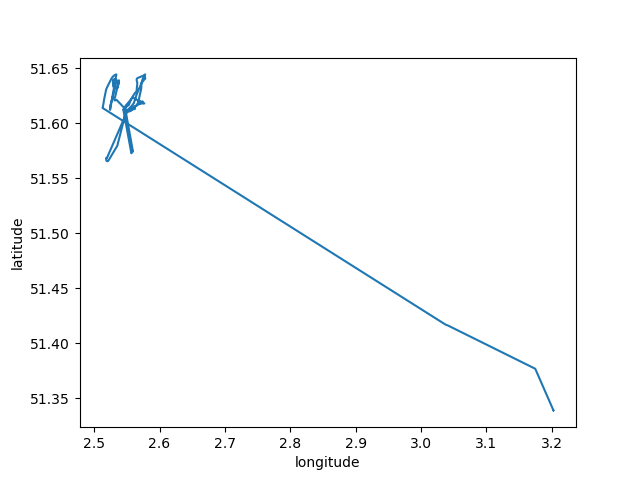

In [11]:
# lets plot the navigation of your file (naive approach)


# first downsample the pings to not plot more than 100000 points (This is more a problem for Matplatlib than for ping btw.)
# remember: creating new ping lists barely costs memory because pings are just references
if len(pings)   > 100000:
    plot_pings = pings[::int(len(pings)//100000)]
else:
    plot_pings = pings

# plot_pings is now python list that contains a subset of the pings
# lets iterator of this list and get the navigation data

lat = []
lon = []
for p in tqdm(plot_pings):
    # each ping has a function called get_geolocation
    # this function returns a Geolocation object holding the latitude and longitude of the transducer at the time of the ping
    # and also the attitude data (pitch, roll, heave, heading)
    # The geolocation was created during pinginterface initialization above
    # This will thus also be very fast
    g = p.get_geolocation()
    lat.append(g.latitude)
    lon.append(g.longitude)

# create a figure
fig, ax = create_figure("navigation")
ax.plot(lon, lat, label="navigation")
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")


In [12]:
# So far so good, but this does not yet give a good overview over the data does it?
# Lets first order your pings into surveys and then plot the navigation of each survey

# For this: lets split the pings into containers depending on the time difference between the pings
# Here is the rational: between surveys recording is often turned off and the ship moves to a new location
# So we break the pings into new containers when the time difference between pings is larger than 15 minutes
# you can do this with a simple loop in python, but for convenience a PingContainer has a function that does this for you

# Note: the function returns a list of PingContainers
ping_containers = fm.pings().get_sorted_by_time().break_by_time_diff(15 * 60)

# lets print some information about the ping containers
for i,p in enumerate(ping_containers):
    print("ping container nr {} with {} pings".format(i, len(p)))

# If you only see one container, then your files do not contain gaps between pings larger than 15 minutes

ping container nr 0 with 10670 pings
ping container nr 1 with 100098 pings
ping container nr 2 with 10192 pings
ping container nr 3 with 8492 pings
ping container nr 4 with 193 pings
ping container nr 5 with 1252 pings
ping container nr 6 with 26 pings
ping container nr 7 with 696 pings
ping container nr 8 with 24310 pings
ping container nr 9 with 45012 pings
ping container nr 10 with 4408 pings
ping container nr 11 with 92450 pings
ping container nr 12 with 15200 pings
ping container nr 13 with 60544 pings
ping container nr 14 with 21804 pings
ping container nr 15 with 11804 pings
ping container nr 16 with 74934 pings


In [13]:
# lets get the navigation data for each ping in each container

# get number of pings in the ping_containers
total = np.sum([len(p) for p in ping_containers])

# create progressbar
prg = tqdm(total=total, desc="Get navigation from pings")

# create dictionary to store the navigation data
# Note: defaultdict is a special dictionary that automatically creates a new list if you try to access a key that does not exist
nav_locations = defaultdict(list)

for i, pings in enumerate(ping_containers):
    prg.set_description("ping_container nr {}".format(i))

    for p in pings:
        # sort the navigation data into the list depending on ping_container index
        g = p.get_geolocation()
        nav_locations[i].append([g.latitude,g.longitude])

        # update the progressbar
        prg.update(1)


Get navigation from pings:   0%|          | 0/482085 [00:00<?, ?it/s]

In [16]:
# This code uses ipyleaflet for plotting the navigaiton data on background map (needs internet)
# the code is thus unreleated to ping

from ipyleaflet import Map, basemaps, basemap_to_tiles, AntPath, projections, Marker, AwesomeIcon
from ipywidgets import Layout, HTML
from matplotlib import colormaps,colors

# create a colormap for the different surveys
cmap = colormaps.get_cmap("tab20")

# create a map
m = Map(
    basemap=basemap_to_tiles(basemaps.Esri.NatGeoWorldMap),
    center=(np.nanmedian(lat), np.nanmedian(lon)),
    layout=Layout(width='80%', height='600px'),
    zoom=9,
    crs=projections.EPSG3857
)

# for each survey create an AntPath
for k,n in nav_locations.items():

    ant_path = AntPath(
        locations=n,
        color=colors.to_hex(cmap(k))
    )

    # add the AntPath to the map
    m.add(ant_path)

    # create a marker for the first location of the survey
    icon = AwesomeIcon(
        name='ship',
        marker_color="white",
        icon_color=colors.to_hex(cmap(k)),
        #spin=True
        )
    marker = Marker(
        location = n[0],
        icon=icon,
        title=str(k)
    )
    message = HTML()
    message.value = str(k)
    marker.popup = message

    # add the marker to the map
    m.add(marker)




m

Map(center=[51.61788158822635, 2.565423797821274], controls=(ZoomControl(options=['position', 'zoom_in_text', …

In [17]:
# This is a better overview right?
# if you click on the icons you will see the survey number (ping_contaiener number)

# If you have a nice geotiff for the background, you can add it using localtileserver
# Note: Local tile server will tile you tiff, so don't be afraid to add a large tiff
background_map_path = ""
background_map_path = "/home/ssd/src/themachinethatgoesping/tutorials/usage/map/210412_BELGIUM_BCP_DTM_20m_LAT.tiff"

if background_map_path:
    from localtileserver import get_leaflet_tile_layer, TileClient

    client = TileClient(background_map_path)
    t = get_leaflet_tile_layer(client,band=1,cmap="YlGnBu_r")
    m.add_layer(t)

# Conclusion

That is it for today. Here is what you have learned:

- How to open files (ping opens many files at once)
- Opening files means indexing them, this process can be speed up by using an index file
- Ping evolves around pings and the main function to access them is fm.pings()
- These pings can be sorted into new list and copied as much as you like. This allows for sorting and selecting pings before doing expensive data processing
- Pings are the basic unit of data in themachinethatgoesping. They contain cached data and provide access to the raw datagrams that belong to them.
- Datagrams are only read completely if the datagram is loaded into memory, or if a function is called that requires the datagram data.
- Pings provide high level functions to the user. E.g. get_geolocation which provides the interpolated and transformed geolocation of the pings transducer at ping time. To speed these functions up, some data is cached in the ping object.
- Additionaly showed you how sorting and selecting pings can be used to create a overview of the data by plotting the navigation data onto an interactive map.

Now it is time to play around. Stay tuned for the next tutorial where we will actually access data and do something with that